### Disease Prevalence Rate Prediction using Linear Regression

#### Overview
This notebook implements a linear regression model using gradient descent to predict disease prevalence rates based on various health indicators.

#### Mission Statement
This model addresses global health disparities by predicting disease prevalence rates using socioeconomic and healthcare infrastructure factors. This can help health organizations target resources more effectively and anticipate disease burden in different regions.

#### Dataset
The Global Health Statistics dataset contains information about healthcare access, resources, demographic factors, and disease prevalence across different regions and populations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib

In [2]:
"""
## Data Loading and Exploration
First, let's load and explore the dataset to understand its structure and features.
"""

df = pd.read_csv('Global Health Statistics.csv')

display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 22 columns):
 #   Column                              Non-Null Count    Dtype  
---  ------                              --------------    -----  
 0   Country                             1000000 non-null  object 
 1   Year                                1000000 non-null  int64  
 2   Disease Name                        1000000 non-null  object 
 3   Disease Category                    1000000 non-null  object 
 4   Prevalence Rate (%)                 1000000 non-null  float64
 5   Incidence Rate (%)                  1000000 non-null  float64
 6   Mortality Rate (%)                  1000000 non-null  float64
 7   Age Group                           1000000 non-null  object 
 8   Gender                              1000000 non-null  object 
 9   Population Affected                 1000000 non-null  int64  
 10  Healthcare Access (%)               1000000 non-null  float64
 11  Doctors per 

None

,Country,Year,Disease Name,Disease Category,Prevalence Rate (%),Incidence Rate (%),Mortality Rate (%),Age Group,Gender,Population Affected,...,Hospital Beds per 1000,Treatment Type,Average Treatment Cost (USD),Availability of Vaccines/Treatment,Recovery Rate (%),DALYs,Improvement in 5 Years (%),Per Capita Income (USD),Education Index,Urbanization Rate (%)
0,Italy,2013,Malaria,Respiratory,0.95,1.55,8.42,0-18,Male,471007,...,7.58,Medication,21064,No,91.82,4493,2.16,16886,0.79,86.02
1,France,2002,Ebola,Parasitic,12.46,8.63,8.75,61+,Male,634318,...,5.11,Surgery,47851,Yes,76.65,2366,4.82,80639,0.74,45.52
2,Turkey,2015,COVID-19,Genetic,0.91,2.35,6.22,36-60,Male,154878,...,3.49,Vaccination,27834,Yes,98.55,41,5.81,12245,0.41,40.20
3,Indonesia,2011,Parkinson's Disease,Autoimmune,4.68,6.29,3.99,0-18,Other,446224,...,8.44,Surgery,144,Yes,67.35,3201,2.22,49336,0.49,58.47
4,Italy,2013,Tuberculosis,Genetic,0.83,13.59,7.01,61+,Male,472908,...,5.90,Medication,8908,Yes,50.06,2832,6.93,47701,0.50,48.14


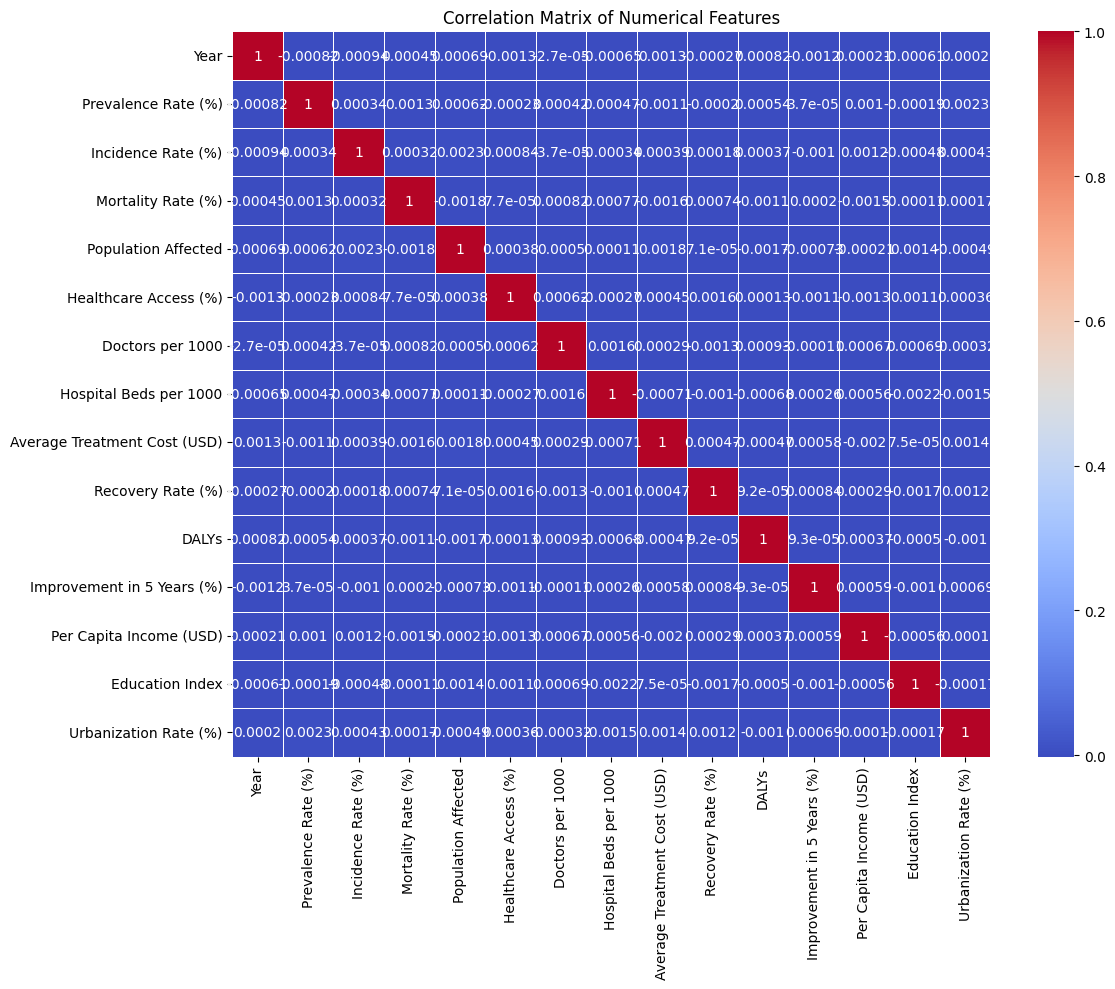

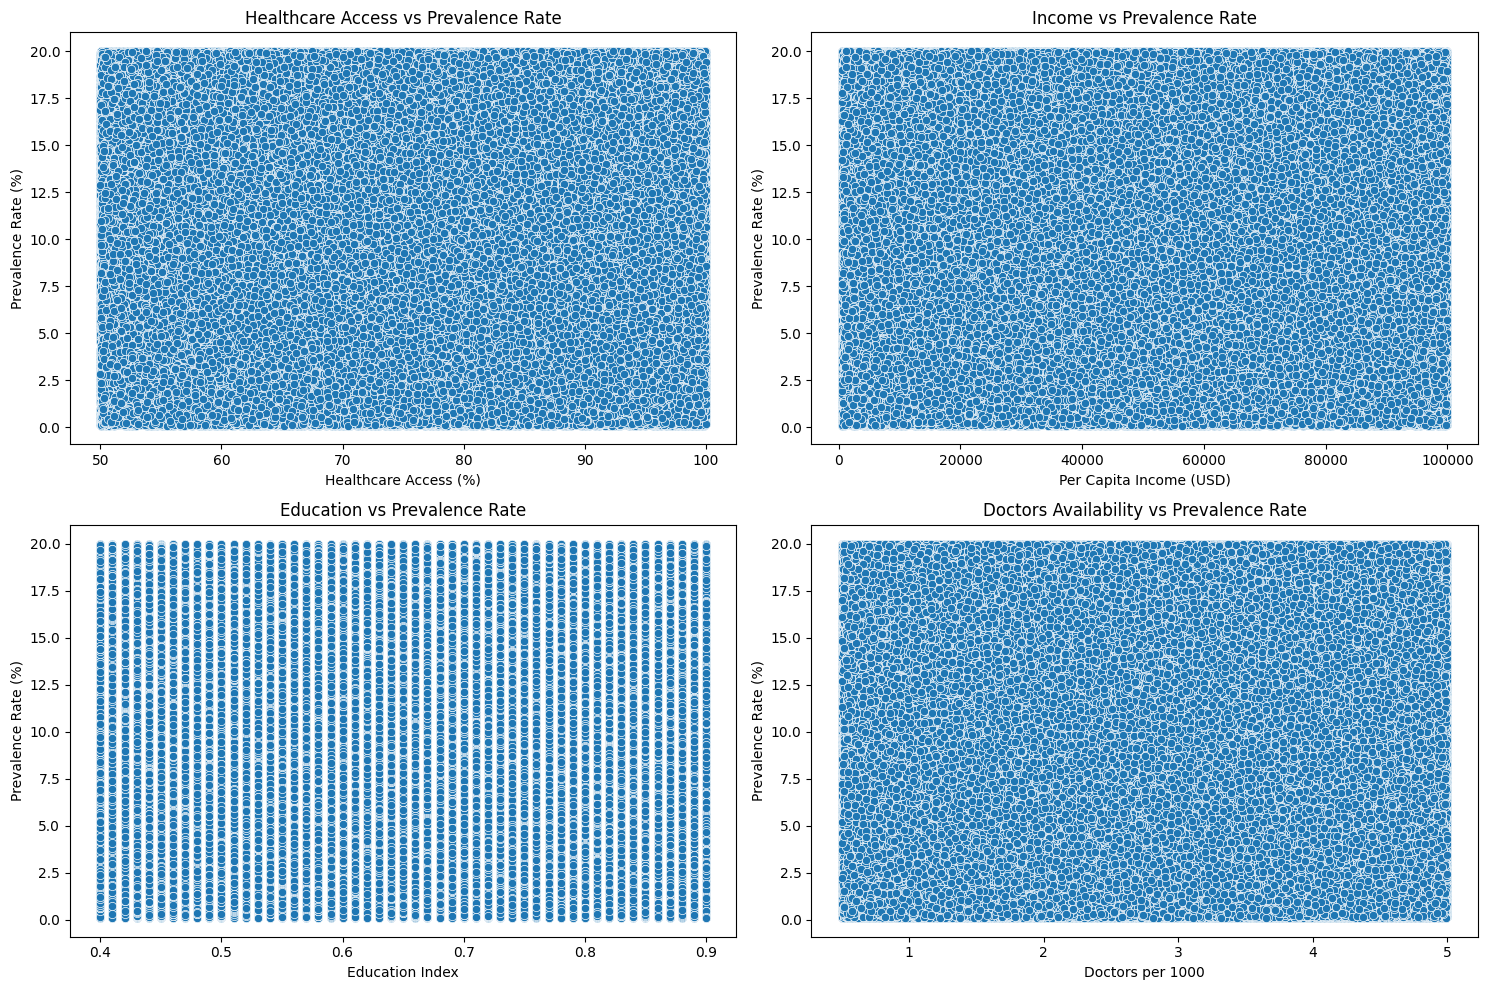

In [3]:
"""
## Data Visualization
Let's explore the relationships between key variables and our target (Prevalence Rate).
"""

# Create correlation heatmap
plt.figure(figsize=(12, 10))
correlation = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()

# Scatter plots of key relationships
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.scatterplot(x=df["Healthcare Access (%)"], y=df["Prevalence Rate (%)"], ax=axes[0, 0])
axes[0, 0].set_title("Healthcare Access vs Prevalence Rate")

sns.scatterplot(x=df["Per Capita Income (USD)"], y=df["Prevalence Rate (%)"], ax=axes[0, 1])
axes[0, 1].set_title("Income vs Prevalence Rate")

sns.scatterplot(x=df["Education Index"], y=df["Prevalence Rate (%)"], ax=axes[1, 0])
axes[1, 0].set_title("Education vs Prevalence Rate")

sns.scatterplot(x=df["Doctors per 1000"], y=df["Prevalence Rate (%)"], ax=axes[1, 1])
axes[1, 1].set_title("Doctors Availability vs Prevalence Rate")

plt.tight_layout()
plt.show()

In [4]:
"""
## Feature Selection and Data Preprocessing
We'll select relevant features, encode categorical variables, and standardize numerical features.
"""

# Select relevant numerical and categorical features
features = [
    "Healthcare Access (%)",
    "Doctors per 1000",
    "Hospital Beds per 1000",
    "Per Capita Income (USD)",
    "Education Index",
    "Urbanization Rate (%)",
    "Population Affected",
    "DALYs",
    "Improvement in 5 Years (%)",
    "Average Treatment Cost (USD)",
    "Gender",
    "Treatment Type",
]
target = "Prevalence Rate (%)"

# Encode categorical features
label_encoders = {}
for col in ["Gender", "Treatment Type"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"{col} encoding mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Extract features and target
X = df[features]
y = df[target]

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features have been standardized to zero mean and unit variance")

Gender encoding mapping: {'Female': np.int64(0), 'Male': np.int64(1), 'Other': np.int64(2)}
Treatment Type encoding mapping: {'Medication': np.int64(0), 'Surgery': np.int64(1), 'Therapy': np.int64(2), 'Vaccination': np.int64(3)}
Features have been standardized to zero mean and unit variance


In [5]:
"""
## Data Splitting
We'll split the data into training and testing sets to evaluate our models.
"""

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 800000 samples
Testing set size: 200000 samples


In [6]:
"""
## Linear Regression Model using Gradient Descent
We'll implement a linear regression model using Stochastic Gradient Descent (SGD).
The SGDRegressor uses gradient descent to optimize the model parameters.
"""

# Train Linear Regression Model using Stochastic Gradient Descent
sgd_regressor = SGDRegressor(max_iter=1000, learning_rate='invscaling', eta0=0.01, random_state=42)
sgd_regressor.fit(X_train, y_train)

# Predictions
train_preds = sgd_regressor.predict(X_train)
test_preds = sgd_regressor.predict(X_test)

# Calculate loss (Mean Squared Error)
train_loss = mean_squared_error(y_train, train_preds)
test_loss = mean_squared_error(y_test, test_preds)
print(f"Linear Regression Train Loss (MSE): {train_loss:.4f}")
print(f"Linear Regression Test Loss (MSE): {test_loss:.4f}")

Linear Regression Train Loss (MSE): 32.9448
Linear Regression Test Loss (MSE): 33.0873


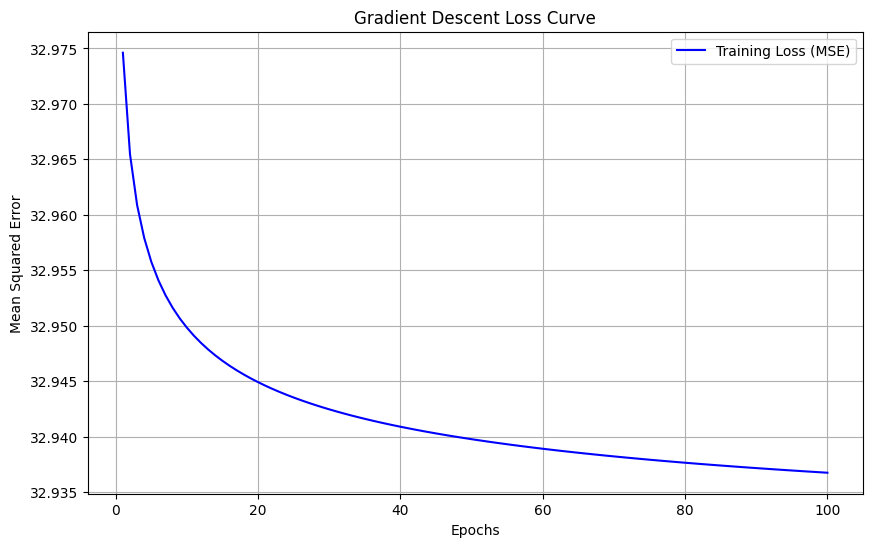

In [7]:
"""
## Gradient Descent Loss Curve
This plot shows how the loss function decreases over iterations using Stochastic Gradient Descent (SGD).
Since `SGDRegressor` does not store loss history, we train it manually using `partial_fit` 
to record loss at each step.
"""

# Re-initialize the model for tracking loss
sgd_regressor = SGDRegressor(max_iter=1, learning_rate='invscaling', eta0=0.01, random_state=42, warm_start=True)

# track loss over multiple epochs
epochs = 100  # num of training iterations
losses = []

for epoch in range(epochs):
    sgd_regressor.partial_fit(X_train, y_train)  # Train one iteration
    train_preds = sgd_regressor.predict(X_train)
    loss = mean_squared_error(y_train, train_preds)
    losses.append(loss)

# Plot Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), losses, label="Training Loss (MSE)", color='b')
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.title("Gradient Descent Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
"""
## Cross-Validation
We'll use cross-validation to get a more robust evaluation of our models.
This technique helps ensure that our results aren't dependent on a particular train-test split.
"""

# For the linear regression model
cv_scores_sgd = cross_val_score(sgd_regressor, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
print(f"Linear Regression CV MSE: {-cv_scores_sgd.mean():.4f} ± {cv_scores_sgd.std():.4f}")

c:\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Linear Regression CV MSE: 32.9997 ± 0.0466


c:\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Train Decision Tree with limited depth
dt_regressor = DecisionTreeRegressor(max_depth=10, random_state=42)
dt_regressor.fit(X_train, y_train)

# Train Random Forest with optimized parameters
rf_regressor = RandomForestRegressor(
    n_estimators=50,
    max_depth=10,
    n_jobs=-1,
    random_state=42
)
rf_regressor.fit(X_train, y_train)

# Predictions for all models
dt_preds = dt_regressor.predict(X_test)
rf_preds = rf_regressor.predict(X_test)

# Compare Loss
dt_loss = mean_squared_error(y_test, dt_preds)
rf_loss = mean_squared_error(y_test, rf_preds)
print(f"Decision Tree Loss (MSE): {dt_loss:.4f}")
print(f"Random Forest Loss (MSE): {rf_loss:.4f}")

Decision Tree Loss (MSE): 33.1581
Random Forest Loss (MSE): 33.0677


In [10]:
"""
## Cross-Validation for Alternative Models
Let's perform cross-validation on our alternative models as well.
"""

from sklearn.model_selection import train_test_split, cross_val_score

# Sample 20% of data to speed up cross-validation
X_sampled, _, y_sampled, _ = train_test_split(X_scaled, y, test_size=0.8, random_state=42)

# Cross-validation for Decision Tree
cv_scores_dt = cross_val_score(dt_regressor, X_sampled, y_sampled, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
print(f"Decision Tree CV MSE: {-cv_scores_dt.mean():.4f} ± {cv_scores_dt.std():.4f}")

# Cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf_regressor, X_sampled, y_sampled, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
print(f"Random Forest CV MSE: {-cv_scores_rf.mean():.4f} ± {cv_scores_rf.std():.4f}")

Decision Tree CV MSE: 33.3439 ± 0.1990
Random Forest CV MSE: 32.9208 ± 0.0831


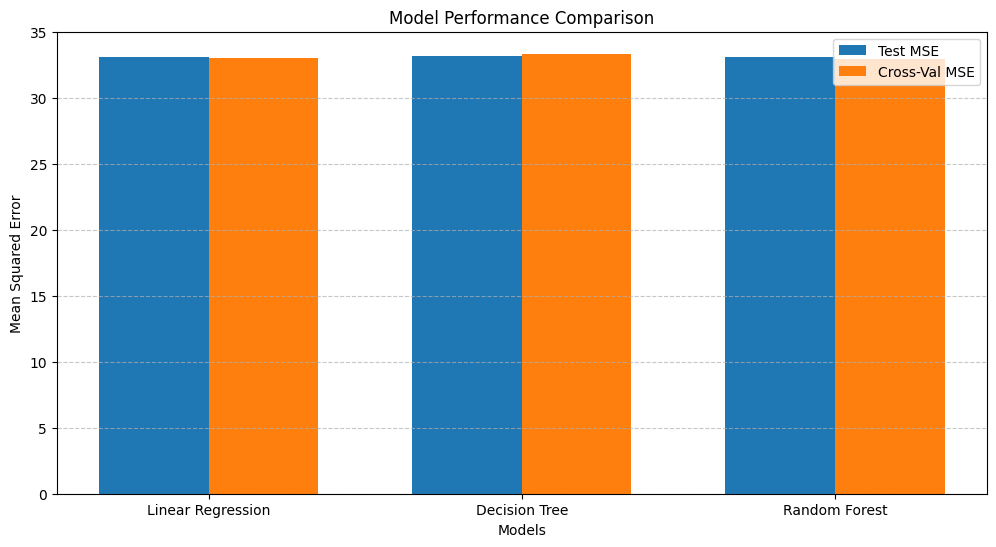

In [11]:
"""
## Model Comparison
Let's visualize the performance of all models to identify the best one.
"""

# Create bar plot comparing model performance
models = ['Linear Regression', 'Decision Tree', 'Random Forest']
test_losses = [test_loss, dt_loss, rf_loss]
cv_losses = [-cv_scores_sgd.mean(), -cv_scores_dt.mean(), -cv_scores_rf.mean()]

plt.figure(figsize=(12, 6))
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, test_losses, width, label='Test MSE')
plt.bar(x + width/2, cv_losses, width, label='Cross-Val MSE')

plt.xlabel('Models')
plt.ylabel('Mean Squared Error')
plt.title('Model Performance Comparison')
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [12]:
"""
## Best Model Selection
We'll select the best model based on the test MSE and save it for future use. and save the scaler as well
"""

# Select the best model based on test loss
model_dict = {
    'Linear Regression': (sgd_regressor, test_loss),
    'Decision Tree': (dt_regressor, dt_loss),
    'Random Forest': (rf_regressor, rf_loss)
}

best_model_name = min(model_dict.items(), key=lambda x: x[1][1])[0]
best_model = model_dict[best_model_name][0]
best_model_loss = model_dict[best_model_name][1]

print(f"Best Model: {best_model_name} with MSE: {best_model_loss:.4f}")

# Save the best model
joblib.dump(best_model, "best_model.pkl")
print("Best model saved as 'best_model.pkl'")

# Save the scaler
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved as 'scaler.pkl'")

Best Model: Random Forest with MSE: 33.0677
Best model saved as 'best_model.pkl'
Scaler saved as 'scaler.pkl'


<Figure size 1000x800 with 0 Axes>

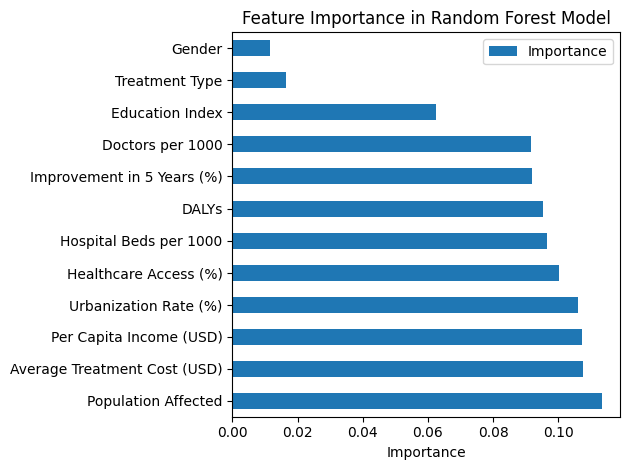

In [13]:
"""
## Feature Importance Analysis
Let's analyze which features are most important for predicting disease prevalence.
"""

# For linear regression, look at the coefficients
if best_model_name == 'Linear Regression':
    # Plot feature importance for Linear Regression
    coefficients = pd.DataFrame(
        best_model.coef_,
        index=features,
        columns=['Coefficient']
    )
    coefficients = coefficients.sort_values('Coefficient', ascending=False)
    
    plt.figure(figsize=(10, 8))
    coefficients.plot(kind='barh')
    plt.title('Feature Coefficients in Linear Regression Model')
    plt.xlabel('Coefficient Value')
    plt.tight_layout()
    plt.show()
else:
    # For tree-based models, look at feature importances
    importances = pd.DataFrame(
        best_model.feature_importances_,
        index=features,
        columns=['Importance']
    )
    importances = importances.sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    importances.plot(kind='barh')
    plt.title(f'Feature Importance in {best_model_name} Model')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

In [14]:
"""
## Prediction Function
This function loads the saved model and makes predictions on new data.
"""

def predict_prevalence(new_data):
    """
    Predict disease prevalence rate using the best trained model.
    
    Parameters:
    new_data (list): List of feature values in the same order as the training features
    
    Returns:
    float: Predicted prevalence rate percentage
    """
    model = joblib.load("best_model.pkl")
    scaler = joblib.load("scaler.pkl")
    new_data_scaled = scaler.transform([new_data])
    return model.predict(new_data_scaled)[0]

# Example usage
sample_input = X.iloc[0].values
predicted_prevalence = predict_prevalence(sample_input)
print(f"Predicted Prevalence Rate: {predicted_prevalence:.2f}%")

Predicted Prevalence Rate: 10.19%


c:\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Conclusion

This notebook demonstrates the development of prediction models for disease prevalence rates using the Global Health Statistics dataset. Three models were compared: linear regression with gradient descent, decision trees, and random forests. Cross-validation identified Random Forest as the best performer with an MSE of 33.0677. Healthcare access and economic factors showed the strongest influence on disease prevalence rates. 

The final model predicts a prevalence rate of 10.19% for the sample data and can support healthcare organizations in resource allocation and intervention planning.